In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

WEIGHT_PATH = os.path.join(MODEL_DIR, 
    "mask_rcnn/fbs_resnet50_da_tf_nominimask_20190225T1120/mask_rcnn_fbs_resnet50_da_tf_nominimask__0030.h5")

log(WEIGHT_PATH)

/home/alejandrovaldes/projects/fetal-brain-segmentation/logs/mask_rcnn/fbs_resnet50_da_tf_nominimask_20190225T1120/mask_rcnn_fbs_resnet50_da_tf_nominimask__0030.h5


Using TensorFlow backend.


In [2]:
from fbs import FBSConfig

class InferenceConfig(FBSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE = 0.001
    MASK_SHAPE = [28, 28]

config = InferenceConfig()
config.display()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13133037560585911679
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10299539456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15403368724855257886
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [4]:
from fbs import FBSDataset
DATASET_DIR = os.path.join(ROOT_DIR, 'data/')
dataset = FBSDataset()
dataset.load_data(DATASET_DIR, subset='validate')
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading data: 100%|██████████| 43/43 [00:46<00:00,  1.04s/it]

Images: 1858
Classes: ['BG', 'brain']


In [5]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR,
                             config=config)
    
print("Loading weights ", WEIGHT_PATH)
model.load_weights(WEIGHT_PATH, by_name=True)

Loading weights  /home/alejandrovaldes/projects/fetal-brain-segmentation/logs/mask_rcnn/fbs_resnet50_da_tf_nominimask_20190225T1120/mask_rcnn_fbs_resnet50_da_tf_nominimask__0030.h5
Re-starting from epoch 30


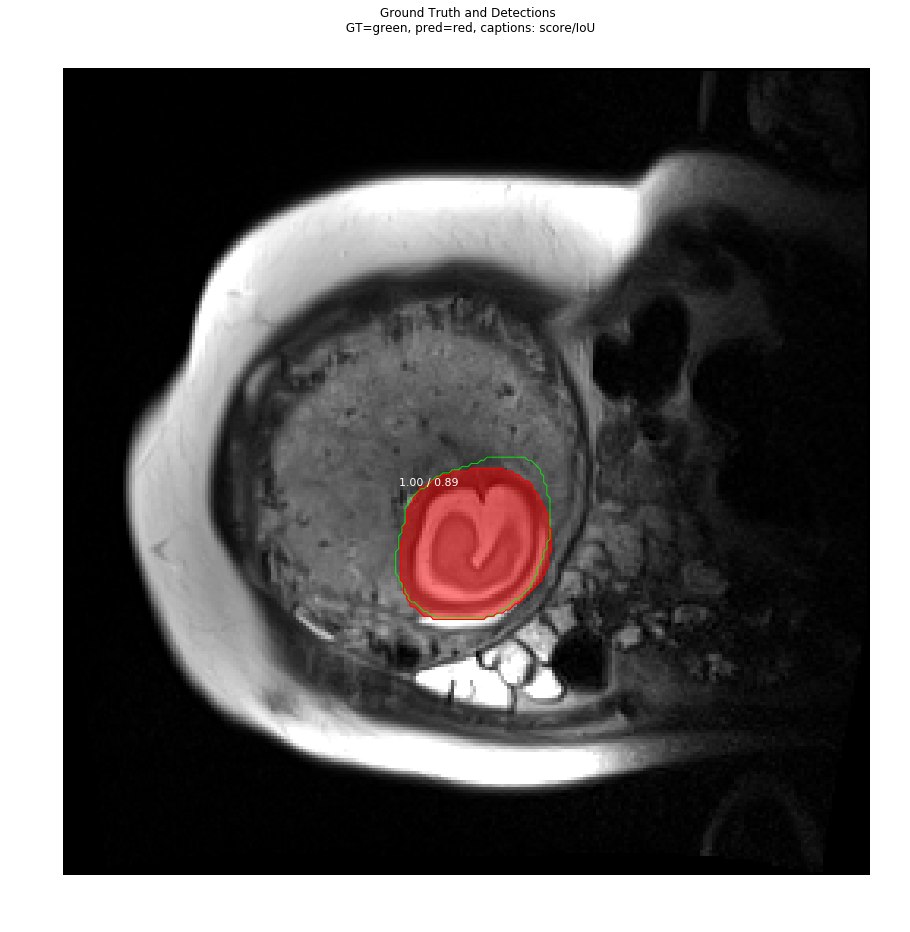


*** No instances to display *** 



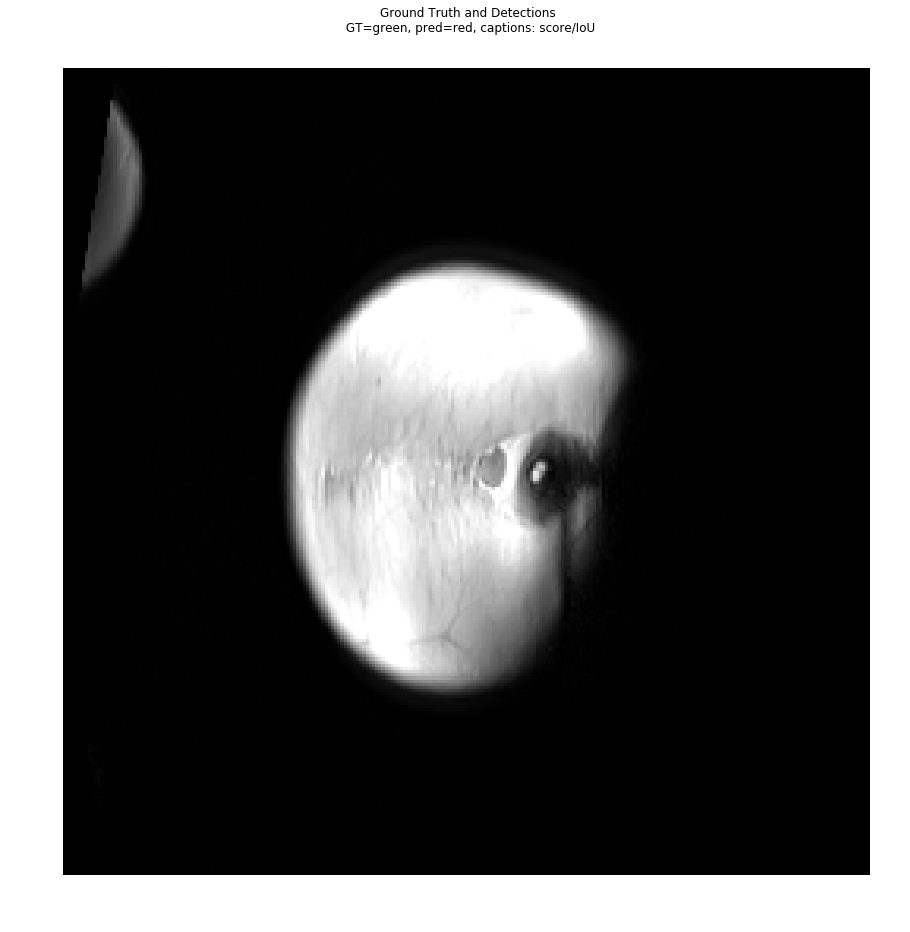

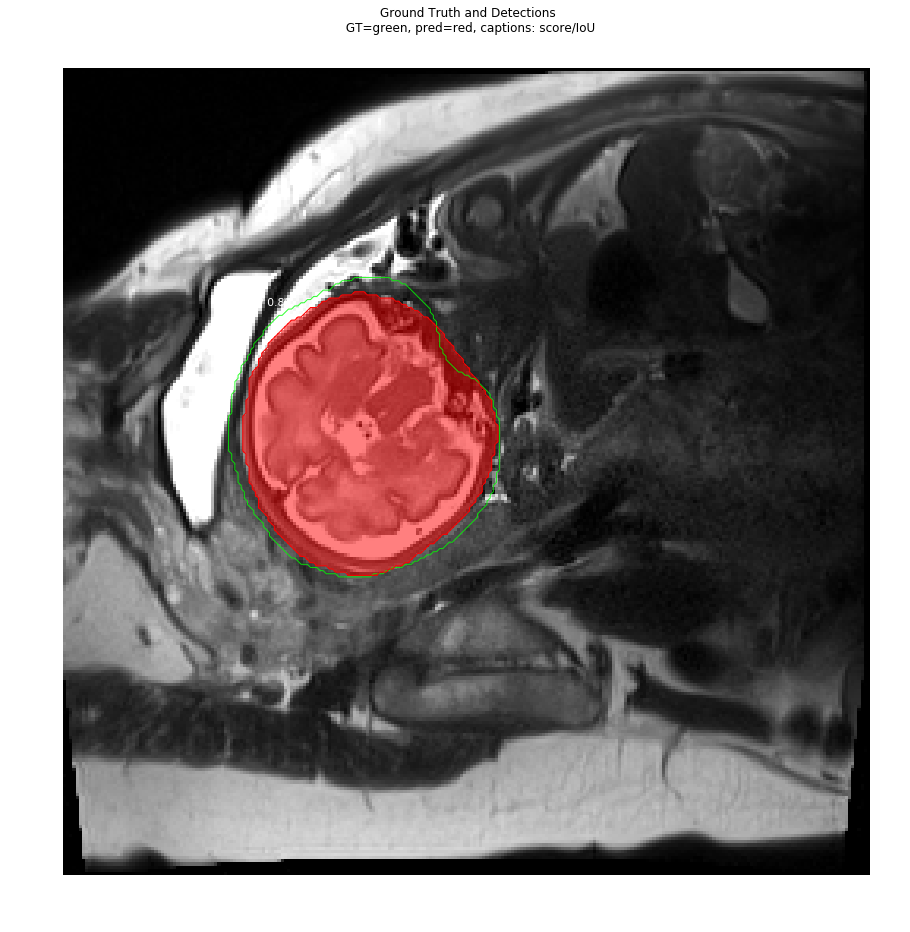

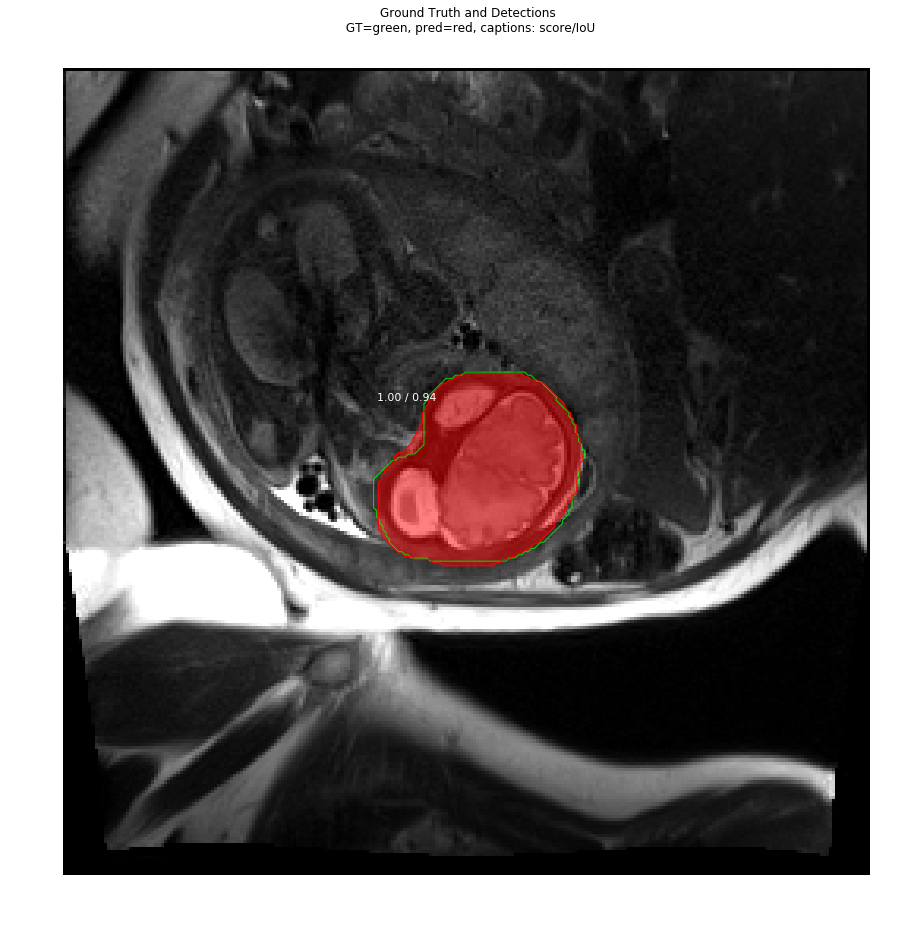

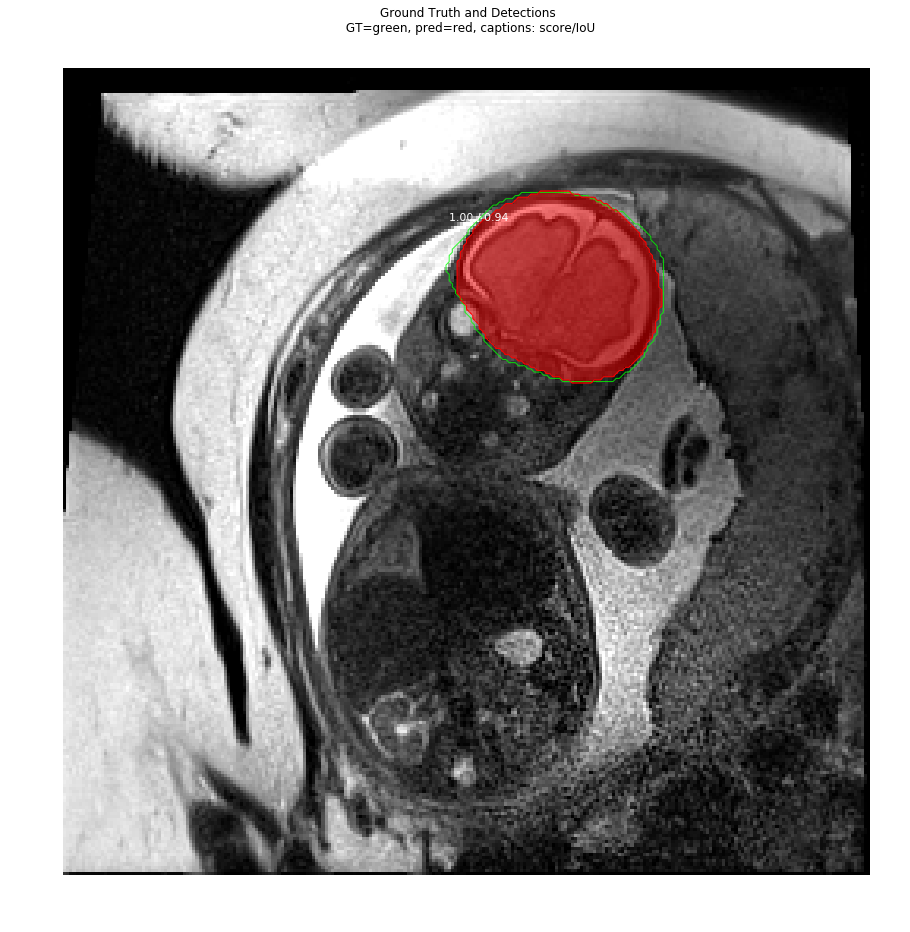

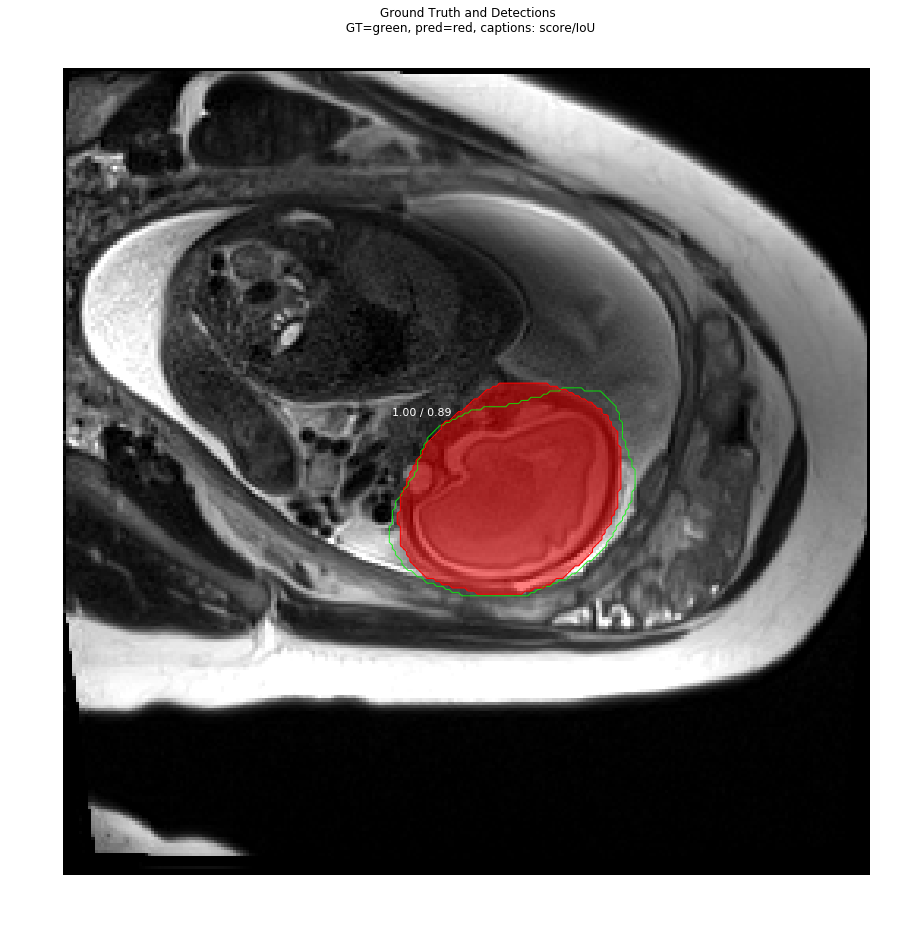

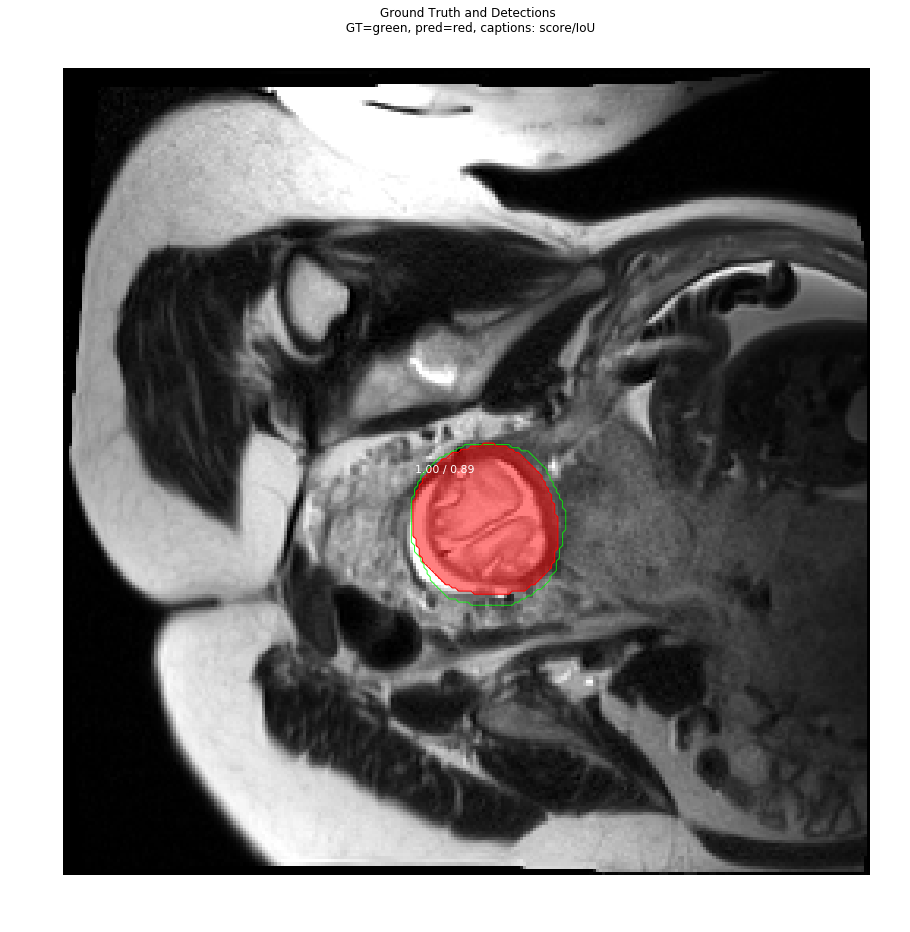


*** No instances to display *** 



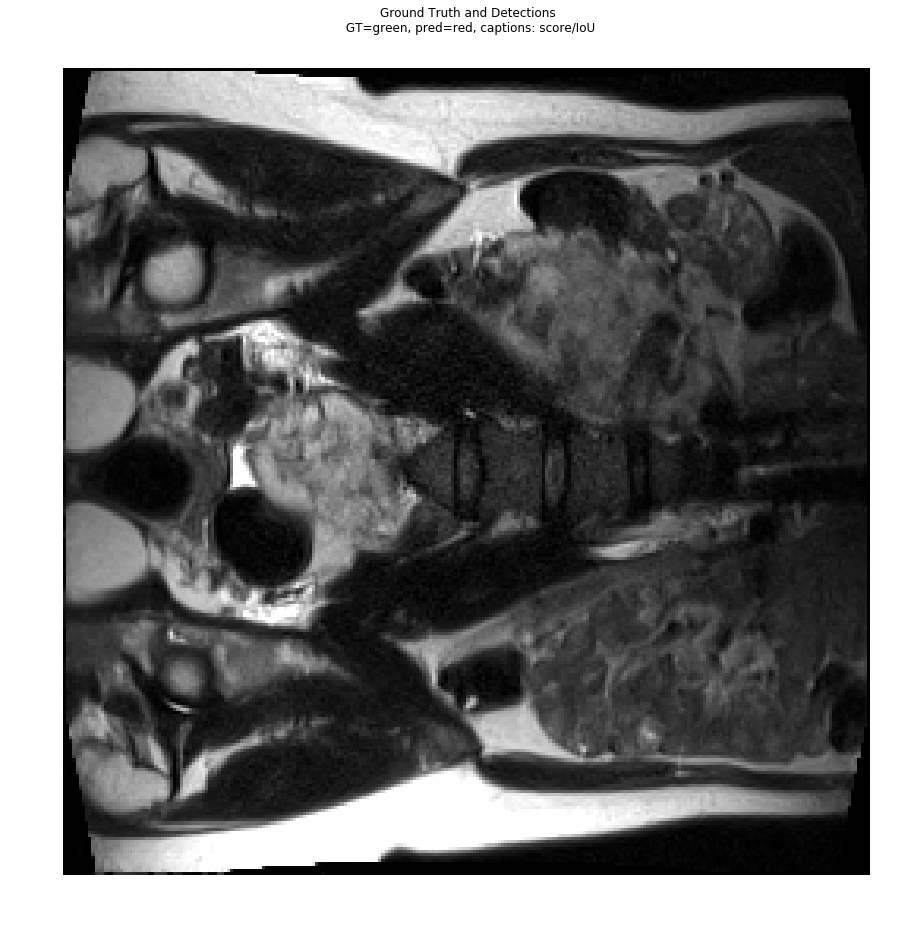

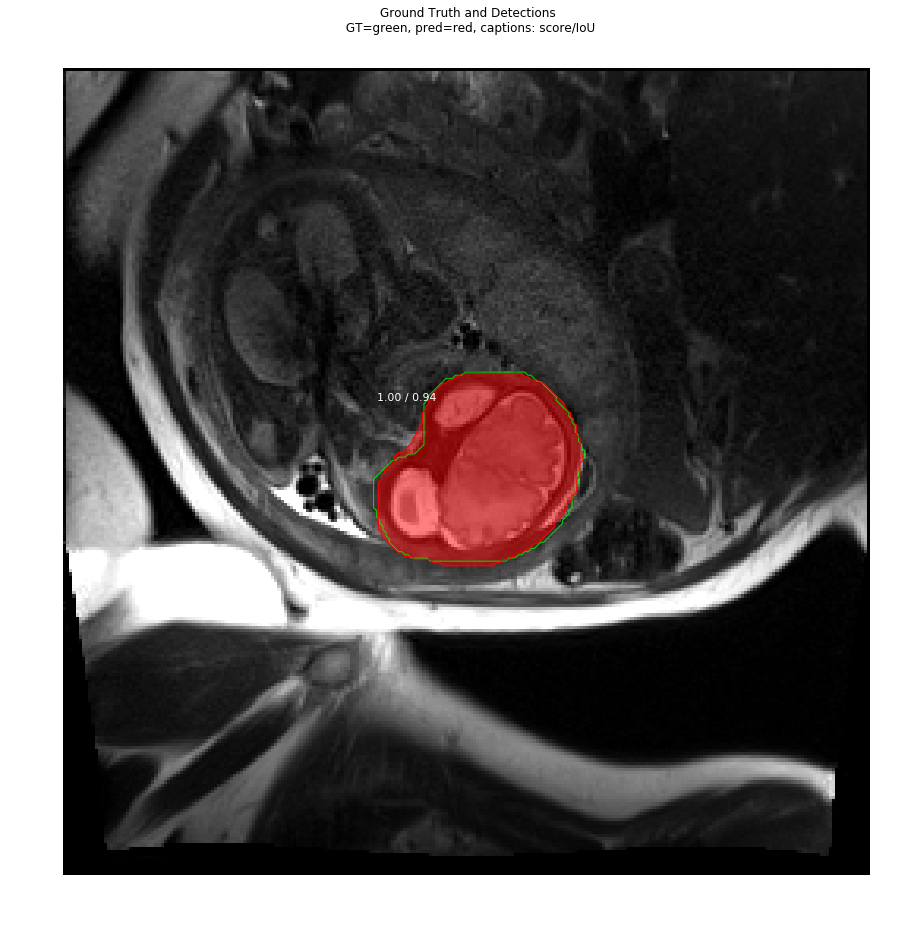

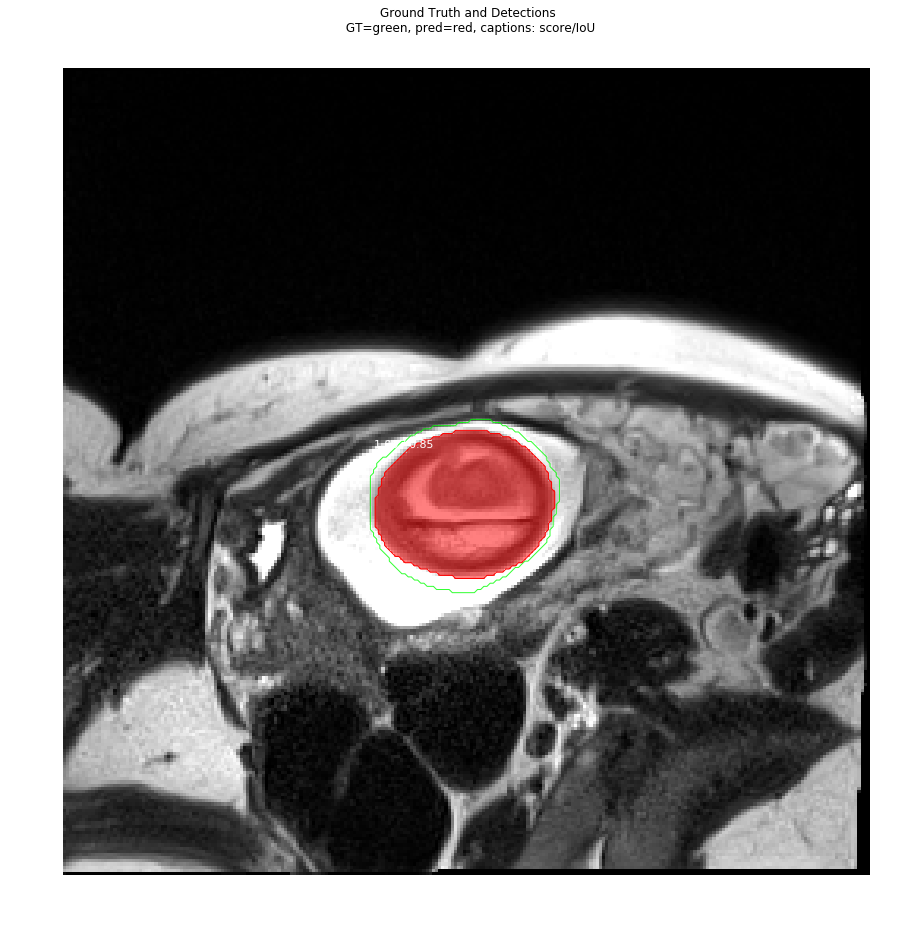

In [6]:
image_ids = np.random.choice(dataset.image_ids, 10)

for i in image_ids: 
    
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, i, use_mini_mask=False)
    
    results = model.detect([image], verbose = 0)
    r = results[0]
    
    visualize.display_differences(image, bbox,
        class_ids, mask, bbox,
        r['class_ids'], r['scores'],
        r['masks'], dataset.class_names,
        show_box=False)